In [1]:
import os

from umap import UMAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import colorcet as cc


from cuml.cluster import KMeans as cuKMeans
from sklearn.cluster import KMeans


def load_result(dir_path, ensemble_size=5):
    pred_res_list = []
    for i in range(ensemble_size):
        pred_res_path = dir_path + f"final_result_{i+1}.csv"
        print("loading", pred_res_path)
        pred_res = pd.read_csv(pred_res_path)
        # change pred_result to pred_result_1, pred_result_2, ...
        pred_res.columns = [f"{col}_{i+1}" if col != "smi_name" else col for col in pred_res.columns]
        pred_res_list.append(pred_res)
    return pred_res_list
        


embedding_dir = "/home/sdl/SDL-LNP/model/evaluation/notebooks/"
data_dir = "/home/sdl/SDL-LNP/model/serverless/test/"


embeddings_path = embedding_dir + "test_result_representation.npz"


pred_res_list = load_result(data_dir)
pred_res = pd.concat(pred_res_list, axis=1, join="outer")
with np.load(embeddings_path) as data:
    embeddings = data["arr_0"]
    
# keep only one smi_name column
pred_res = pred_res.loc[:, ~pred_res.columns.duplicated()]
mean_pred_res = pred_res.groupby("smi_name").mean()
# get mean embedding with same smi_name
smi_names = pred_res["smi_name"].unique()
embeddings_df = pd.DataFrame(embeddings, index=pred_res["smi_name"])
# mean_embeddings = embeddings_df.groupby("smi_name").mean()

# get first embedding with same smi_name
mean_embeddings = embeddings_df.groupby("smi_name").first()

MAPPING_PATH = "/home/sdl/SDL-LNP/model/data_process/220k_library.csv"
mapping_df = pd.read_csv(MAPPING_PATH)
NAME_SMI_PATH = "/home/sdl/SDL-LNP/mapping_table/General_mapping_sampler.csv"
name_smi_df = pd.read_csv(NAME_SMI_PATH)


mapping_df["A_name"] = mapping_df["A_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])
mapping_df["B_name"] = mapping_df["B_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])
mapping_df["C_name"] = mapping_df["C_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])
mapping_df["D_name"] = mapping_df["D_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])


mean_pred_res = pred_res.groupby("smi_name").mean()
# get mean embedding with same smi_name
smi_names = pred_res["smi_name"].unique()
embeddings_df = pd.DataFrame(embeddings, index=pred_res["smi_name"])
# mean_embeddings = embeddings_df.groupby("smi_name").mean()

# get first embedding with same smi_name
mean_embeddings = embeddings_df.groupby("smi_name").first()


loading /home/sdl/SDL-LNP/model/serverless/test/final_result_1.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_2.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_3.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_4.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_5.csv


In [2]:
df = mean_embeddings
# to float32
df = df.astype(np.float32)

# NOTE: mapping_df and mean_embeddings have DIFFERENT order


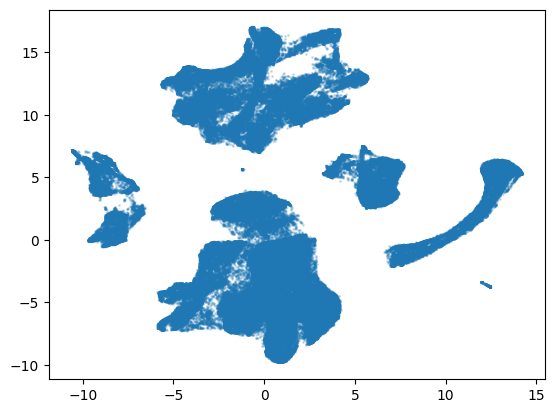

In [3]:
# plot umap and save coordinates
umap_embedding_cache = "/home/sdl/SDL-LNP/model/evaluation/notebooks/umap_coordinates.npy"

if os.path.exists(umap_embedding_cache):
    umap_embedding = np.load(umap_embedding_cache)
else:
    umap = UMAP()
    umap_embedding = umap.fit_transform(df)
    np.save(umap_embedding_cache, umap_embedding)

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.2, s=1)


In [4]:
umap_embedding

array([[ 0.3282369, 15.413798 ],
       [-3.488831 , 13.238289 ],
       [-1.6157485,  2.8974507],
       ...,
       [ 7.201431 ,  3.724537 ],
       [ 5.951372 ,  5.9153905],
       [ 6.324794 ,  3.6186144]], dtype=float32)

<Axes: >

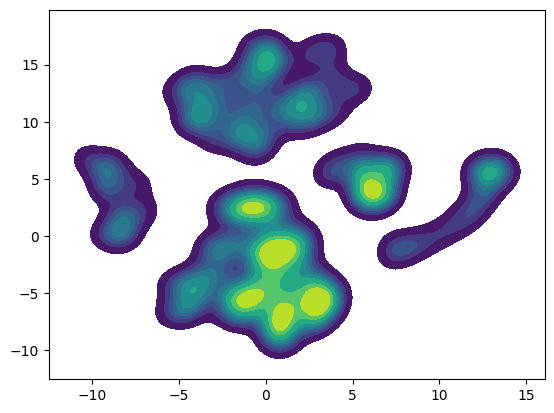

In [5]:
# seaborn kde plot

sns.kdeplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], fill=True, cmap="viridis")

In [25]:
# kmeans clustering with cuml

N = 64

# kmeans = KMeans(n_clusters=N)
# kmeans.fit(df)

kmeans = cuKMeans(n_clusters=N)
kmeans.fit(df)

colors = kmeans.labels_

# map to palette
palette = sns.color_palette(cc.glasbey_hv, n_colors=N )
colors = [palette[i] for i in colors]

# plot kmeans
sns.set_theme(style="white")
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
            color=colors, alpha=0.3, s=1,)

ValueError: Unsupported dtype object

In [ ]:
# get cluster size
cluster_size = np.bincount(kmeans.labels_)
cluster_size

array([ 3833,  1286,  6127, 12046,    51,   764,  9251,  5120,  4602,
        4728,  1646,   981, 13531,    74,     4,  6993,  3759,   699,
         867,  1647,  9841,  5265,    63,  3033,   277,   543, 13626,
         601,  5499,  4802,   468,  1007,  4414,  2463,  7181,  6095,
        5820,  5645,  3397,   408,  3239,  2065,  1055,  4144,   307,
         856,  1423,   520,    36,  6743,  6573,   105,  1254,  3925,
        3001,   370,  7190,  4519,  5704,  2886,   480,   241,  3072,
        3019])

In [ ]:
import plotly.express as px
from collections import Counter

def count_combination(structures):
    res_list = []
    # structures is a list of smiles
    idx = mapping_df.index[mapping_df["combined_mol_SMILES"].isin(structures)].tolist()
    A = mapping_df.loc[idx, "A_name"]
    B = mapping_df.loc[idx, "B_name"]
    C = mapping_df.loc[idx, "C_name"]
    D = mapping_df.loc[idx, "D_name"]
    
    for a, b, c, d in zip(A, B, C, D):
        res_list.append([a, b, c, d])
    # count table for each unique A or unqiue B or unique C or unique D
    return res_list

def plot_sankey(structures):
    data = count_combination(structures)
    counter = Counter(tuple(x) for x in data)
    df = pd.DataFrame(counter.items(), columns=["combination", "count"])
    df["A"] = df["combination"].apply(lambda x: x[0])
    df["B"] = df["combination"].apply(lambda x: x[1])
    df["C"] = df["combination"].apply(lambda x: x[2])
    df["D"] = df["combination"].apply(lambda x: x[3])


    
    fig = px.parallel_categories(df, dimensions=["A", "B", "C", "D"],)
    fig.show()
                              

def sampling(n_query, clusters, query_idx, cluster_size_thres=50):
    sample_res = []
    idx2cluster_mapping = {idx: clusters[idx] for idx in query_idx}  # e.g. {0: c0, 1: c0, 2: c1, 3: c1, ...}
    local_clusters = clusters[query_idx]  # e.g. [c0, c0, c1, c1, ...]
    cluster2size_mapping = {i: np.sum(local_clusters == i) for i in np.unique(local_clusters)}  # e.g. {c0: [0, 1], c1: [2, 3], ...}
    cluster2idx_mapping = {i: [] for i in np.unique(local_clusters)}
    for idx, cluster in idx2cluster_mapping.items():
        cluster2idx_mapping[cluster].append(idx)
    sorted_clusters = sorted(cluster2size_mapping.keys(), 
                             key=lambda x: cluster2size_mapping[x])
    # remove clusters smaller than size threshold
    sorted_clusters = [c for c in sorted_clusters if cluster2size_mapping[c] >= cluster_size_thres]
    # round robin sampling
    j = 0
    while len(sample_res) < n_query:
        cluster = sorted_clusters[j % len(sorted_clusters)]
        cluster_indices = cluster2idx_mapping[cluster]
        if len(cluster_indices) == 0:
            j += 1
            continue
        selected_idx = np.random.choice(cluster_indices, 1)[0]
        # remove selected index from cluster2idx_mapping
        cluster2idx_mapping[cluster].remove(selected_idx)
        cluster2size_mapping[cluster] -= 1
        sample_res.append(selected_idx)
        print(f"selected_idx: {selected_idx} from cluster {cluster}; cluster size: {cluster2size_mapping[cluster]+1}")
        j += 1

    return sample_res

In [ ]:
df.reset_index(inplace=True)
all_idx = df.index

diversity_sample_idx = sampling(92 * 2, kmeans.labels_, all_idx)

selected_idx: 60874 from cluster 4; cluster size: 51
selected_idx: 157486 from cluster 22; cluster size: 63
selected_idx: 37149 from cluster 13; cluster size: 74
selected_idx: 47663 from cluster 51; cluster size: 105
selected_idx: 104050 from cluster 61; cluster size: 241
selected_idx: 23430 from cluster 24; cluster size: 277
selected_idx: 148950 from cluster 44; cluster size: 307
selected_idx: 98167 from cluster 55; cluster size: 370
selected_idx: 51569 from cluster 39; cluster size: 408
selected_idx: 43068 from cluster 30; cluster size: 468
selected_idx: 86383 from cluster 60; cluster size: 480
selected_idx: 163856 from cluster 47; cluster size: 520
selected_idx: 104021 from cluster 25; cluster size: 543
selected_idx: 193252 from cluster 27; cluster size: 601
selected_idx: 125758 from cluster 17; cluster size: 699
selected_idx: 182388 from cluster 5; cluster size: 764
selected_idx: 209605 from cluster 45; cluster size: 856
selected_idx: 78959 from cluster 18; cluster size: 867
select

In [26]:
diversity_sampled_df = df.iloc[diversity_sample_idx]
diversity_sampled_df

,index,smi_name,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
60874,60874,CCCCCCC(CCCC)C(=O)N(CCN1CCCCC1)C(CCCCC)C(=O)NC...,0.003866,0.090088,0.042664,0.084534,0.016571,0.003485,0.022659,0.007511,...,-0.011551,-0.101807,0.120605,-0.014153,-0.079773,-0.062256,-0.001151,-0.043213,-0.050171,0.045624
157486,157486,CCCCCCCCCCCC(=O)N(CCN1CCNCC1)C(CCCCCOC(=O)C(CC...,-0.007317,0.086731,0.041809,0.087158,0.007042,0.006924,0.025604,0.046509,...,-0.001649,-0.115234,0.113098,0.000394,-0.078918,-0.047272,-0.030563,-0.040802,-0.053223,0.055969
37149,37149,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC(C)(C)C)N(C(=O...,-0.015472,0.096802,0.044220,0.086121,0.007751,0.001104,0.012283,0.041595,...,-0.022018,-0.112244,0.104004,-0.014557,-0.085388,-0.023758,-0.039246,-0.035034,-0.046844,0.062195
47663,47663,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NCS(=O)(=O)c1ccc...,0.011444,0.095520,0.038055,0.088684,0.021408,0.009987,0.021881,0.000480,...,-0.015793,-0.102112,0.120667,-0.022034,-0.078796,-0.063843,-0.005264,-0.043701,-0.049042,0.041809
104050,104050,CCCCCCCCC(C(=O)NCS(=O)(=O)c1ccc(C)cc1)N(CCCN(C...,-0.014503,0.091492,0.038757,0.074707,0.012321,0.000852,0.029205,0.048828,...,-0.026840,-0.116455,0.095703,-0.013176,-0.079712,-0.036255,-0.039032,-0.034576,-0.049072,0.060272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79194,79194,CCCCCCCC/C=C\CCCCCCCC(C(=O)NC(C)(C)C)N(C(=O)CC...,-0.011658,0.085571,0.038300,0.083313,0.002556,0.006519,0.021835,0.059235,...,-0.012802,-0.116089,0.102356,-0.009270,-0.077820,-0.040619,-0.039551,-0.046967,-0.044098,0.056000
2960,2960,C#CCCCCCCCCC(=O)N(CCCN1CCCC1)C(CCCCCCCC)C(=O)N...,-0.012726,0.085449,0.036346,0.084045,0.002665,0.003937,0.021790,0.054077,...,-0.016281,-0.117371,0.100281,-0.011742,-0.079712,-0.041931,-0.041656,-0.049866,-0.040466,0.058289
95818,95818,CCCCCCCC=CC(=O)N(c1nc2ccccc2[nH]1)C(CCCCCOC(=O...,-0.011612,0.086609,0.038788,0.084229,0.002161,0.006256,0.026947,0.054718,...,-0.017487,-0.116394,0.103638,-0.005447,-0.073486,-0.041321,-0.036987,-0.046204,-0.047394,0.059418
59858,59858,CCCCCCC(CCC)OC(=O)CCCCC(=O)N(CCN(C)C)C(CCCCC)C...,-0.011604,0.085144,0.036011,0.087036,0.002028,0.005913,0.023621,0.056213,...,-0.013397,-0.116211,0.104553,-0.008118,-0.074890,-0.041443,-0.038757,-0.048187,-0.044495,0.057831


In [27]:
structures = diversity_sampled_df["smi_name"].values
plot_sankey(structures)

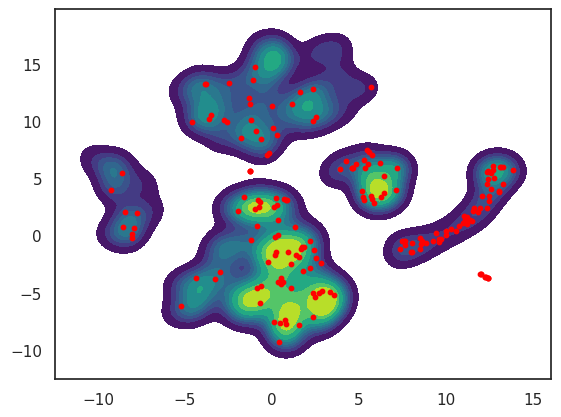

In [28]:
# kde weight by predictive variance

sns.kdeplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], fill=True, cmap="viridis")

# overlay the selected points
plt.scatter(umap_embedding[diversity_sample_idx, 0], umap_embedding[diversity_sample_idx, 1], s=10, c="red")

In [30]:
# # plot kmeans
# sns.set_theme(style="white")
# colors = kmeans.labels_
# # map to palette
# palette = sns.color_palette(cc.glasbey_hv, n_colors=N )
# colors = [palette[i] for i in colors]

# plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
#             color=colors, alpha=0.2, s=1,)

# plt.scatter(umap_embedding[diversity_sample_idx, 0], umap_embedding[diversity_sample_idx, 1], s=10, c="red")

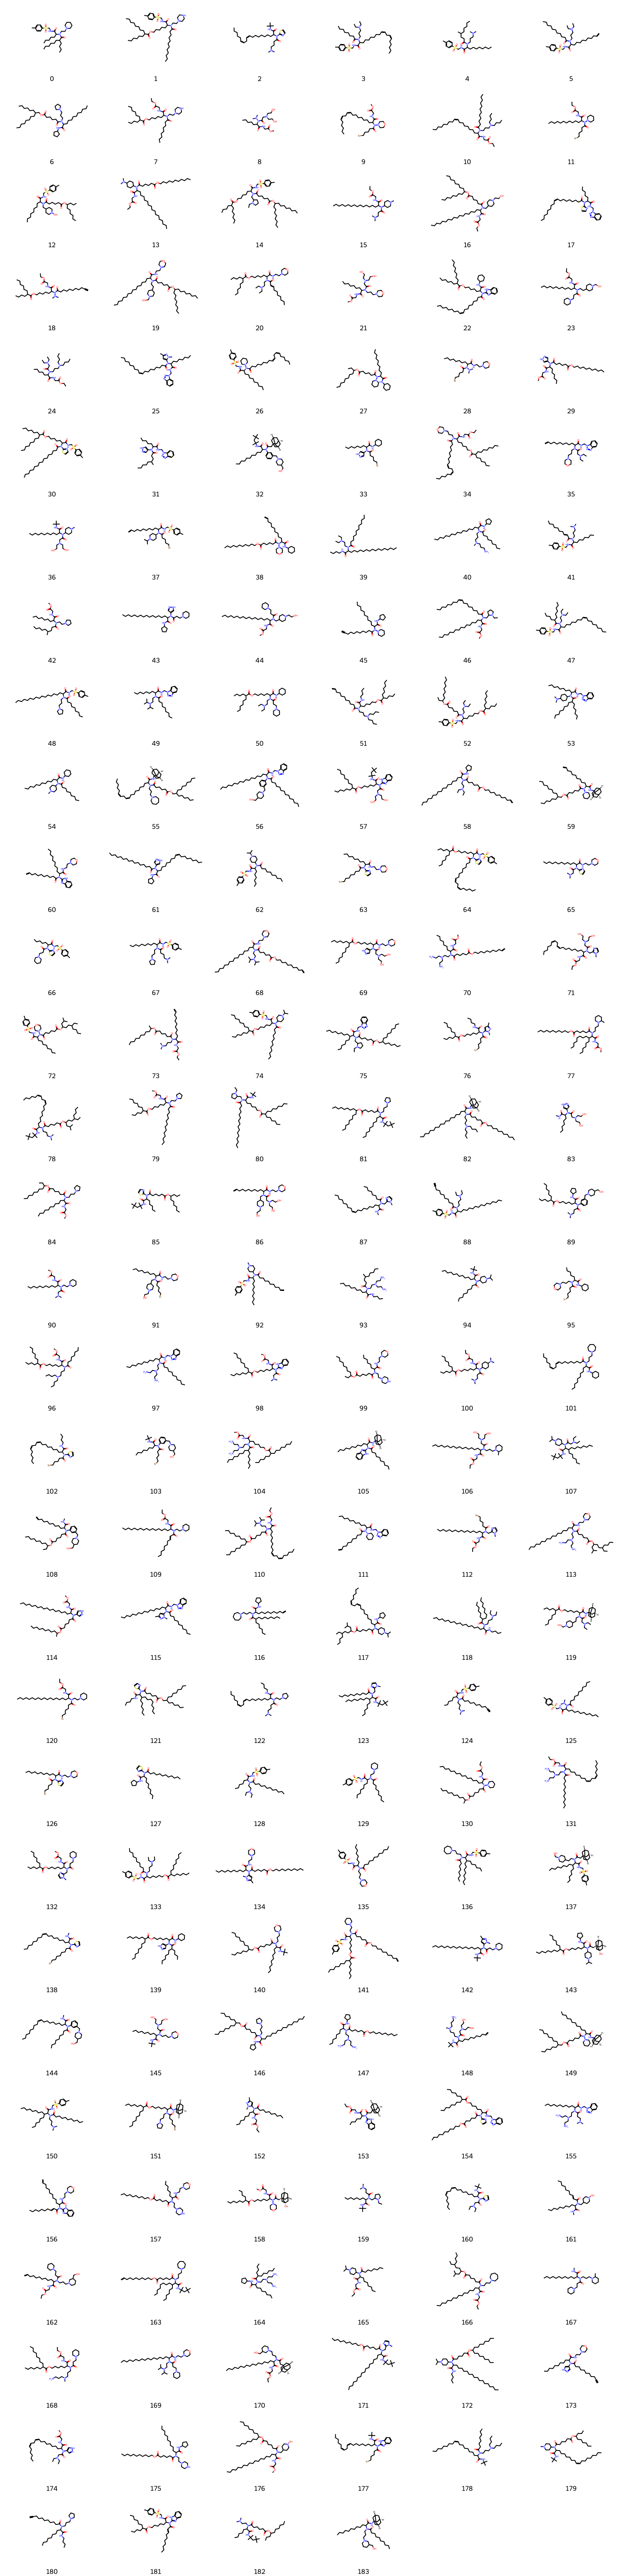

In [31]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

# draw the structures, structures is a list of smiles
mols = [Chem.MolFromSmiles(smi) for smi in structures]

Draw.MolsToGridImage(mols, molsPerRow=6, subImgSize=(250, 200), legends=[f"{i}" for i in range(len(mols))], maxMols=len(mols))

In [32]:
# get the selected structures in mapping_df
idx = mapping_df.index[mapping_df["combined_mol_SMILES"].isin(structures)].tolist()
structures_df = mapping_df.loc[idx].reset_index(drop=True)

In [33]:
structures_df

,id,combined_mol_SMILES,A_smiles,B_smiles,C_smiles,D_smiles,A_name,B_name,C_name,D_name
0,4638,CCCCCCC(CCC)OC(=O)CCCCC(=O)N(CCN(C)C)C(CCCCC)C...,NCCN(C)C,CC(CC(C)([N+]#[C-])C)(C)C,CCCCCC=O,OC(CCCCC(OC(CCCCCC)CCC)=O)=O,D5616,T1054,H0133,D1380+A0161
1,7658,CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(C(CCCCCCCCC)C(=O...,NN1CCCCC1,O=S(C[N+]#[C-])(C1=CC=C(C)C=C1)=O,CCCCCCCCCC=O,CCCCC/C=C\C/C=C\CCCCCCCC(O)=O,A2241,T1046,D0032,L0124
2,8300,C=CCCCCCCCCC(=O)N(C(CCCCCCCCCC)C(=O)NCn1nnc2cc...,NN1CCCCC1,[C-]#[N+]CN1C(C=CC=C2)=C2N=N1,CCCCCCCCCCC=O,OC(CCCCCCCCC=C)=O,A2241,I0455,U0009,U0007
3,9404,CCCCCCCCCCCC(C(=O)NCC(=O)OCC)N(C(=O)CCCCBr)N1C...,NN1CCCCC1,O=C(C[N+]#[C-])OCC,CCCCCCCCCCCC=O,O=C(O)CCCCBr,A2241,I0562,D0979,5-bromopentanoic acid
4,9640,CCCCCCCCCCCCCCCC(C(=O)NCC(=O)OCC)N(C(=O)CCCCC(...,NN1CCCCC1,O=C(C[N+]#[C-])OCC,CCCCCCCCCCCCCCCC=O,OC(CCCCC(OC(C)CCCCCCCCC)=O)=O,A2241,I0562,H0071,U0027+A0161
...,...,...,...,...,...,...,...,...,...,...
179,217004,CCCCCCCCCCCCCCCC(C(=O)NCC(=O)OCC)N(CCCN1CCCCCC...,NCCCN1CCCCCC1,O=C(C[N+]#[C-])OCC,CCCCCCCCCCCCCCCC=O,CCC(CCC(OC(CCCCC(O)=O)=O)CC(C)C)CCCC,TRC-A809785,I0562,H0071,E0144+A0161
180,217416,C=CCCCCCCCCC(C(=O)NC1CCCC1)N(CCCN1CCCCCC1)C(=O...,NCCCN1CCCCCC1,[C-]#[N+]C1CCCC1,C=CCCCCCCCCC=O,OC(C(CCCCCCCC)CCCCCC)=O,TRC-A809785,C2959,U0011,2-hexyldecanoic acid
181,217898,CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(CCCN1CCCCCC1)C(C...,NCCCN1CCCCCC1,[C-]#[N+]C1CCCCC1,CCCCCCCCCC=O,CCCCC/C=C\C/C=C\CCCCCCCC(O)=O,TRC-A809785,C1438,D0032,L0124
182,219275,C=CCCCCCCCCCOC(=O)CCCCC(=O)N(CCCN1CCCCCC1)C(C(...,NCCCN1CCCCCC1,CC(CC(C)([N+]#[C-])C)(C)C,CCCCCCCCC(CCCCCC)C=O,OC(CCCCC(OCCCCCCCCCC=C)=O)=O,TRC-A809785,T1054,H1461,U0047+A0161


In [34]:
old_exp_input_file = "./initial_184_structures.csv"
old_exp_input_df = pd.read_csv(old_exp_input_file)
# # remove duplicates
# structures_df = structures_df[~structures_df["combined_mol_SMILES"].isin(old_exp_input_df["combined_mol_SMILES"])]
# assert no overlap
assert len(set(structures_df["combined_mol_SMILES"]) & set(old_exp_input_df["combined_mol_SMILES"])) == 0

In [35]:
structures_df.to_csv("./selected_structures.csv", index=False)